In [6]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, precision_recall_curve, auc,
                             f1_score, recall_score, precision_score)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



train_path = "HR_employee_attrition_train.csv"
test_path  = "HR_employee_attrition_test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (1102, 35)
Test shape: (368, 35)


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,34,Travel_Rarely,419,Research & Development,7,4,Life Sciences,1,28,1,...,80,0,13,4,3,12,6,2,11,No
1,36,Travel_Rarely,132,Research & Development,6,3,Life Sciences,1,97,2,...,80,0,5,3,3,1,0,0,0,No
2,22,Travel_Rarely,391,Research & Development,7,1,Life Sciences,1,1878,4,...,80,0,1,2,3,1,0,0,0,Yes
3,39,Travel_Frequently,505,Research & Development,2,4,Technical Degree,1,343,3,...,80,0,20,1,3,19,6,11,8,No
4,36,Non-Travel,894,Research & Development,1,4,Medical,1,1662,4,...,80,0,4,6,3,3,2,1,2,No


columns don’t help prediction

In [7]:
bad_predictors = ['EmployeeCount', 'EmployeeNumber', 'Gender',
                  'MaritalStatus', 'Over18', 'StandardHours']

df_train = df_train.drop(columns=bad_predictors, errors='ignore')
df_test  = df_test.drop(columns=bad_predictors, errors='ignore')


making a numeric target column

In [8]:
df_train['target'] = df_train['Attrition'].map({'Yes': 1, 'No': 0})
df_test['target']  = df_test['Attrition'].map({'Yes': 1, 'No': 0})


checking the class balance

In [9]:
print("Train set distribution:")
print(df_train['target'].value_counts())

print("\nTest set distribution:")
print(df_test['target'].value_counts())


Train set distribution:
target
0    924
1    178
Name: count, dtype: int64

Test set distribution:
target
0    309
1     59
Name: count, dtype: int64


spliting features into numerics and categorics

In [10]:
X = df_train.drop(columns=['Attrition', 'target'])
y = df_train['target']

X_test = df_test.drop(columns=['Attrition', 'target'])
y_test = df_test['target']

# Split into numeric and categorical columns
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Identify ordinal columns based on the provided mapping (moved from preprocessor cell)
ordinal_cols = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'WorkLifeBalance'
]

# Identify nominal categorical columns (excluding the ordinal ones) (moved from preprocessor cell)
nominal_cat_cols = [col for col in cat_cols if col not in ordinal_cols]


# Explicitly cast nominal and ordinal categorical columns to 'object' dtype
for col in nominal_cat_cols: # Loop through nominal_cat_cols defined above
         X[col] = X[col].astype('object')
         X_test[col] = X_test[col].astype('object')

for col in ordinal_cols: # Explicitly cast ordinal columns to object dtype
         X[col] = X[col].astype('object')
         X_test[col] = X_test[col].astype('object')


print("Numeric columns:", numeric_cols)
print("Categorical columns:", cat_cols)
print("Nominal categorical columns:", nominal_cat_cols)
print("Ordinal columns:", ordinal_cols)

Numeric columns: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'OverTime']
Nominal categorical columns: ['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'OverTime']
Ordinal columns: ['Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'WorkLifeBalance']


building preprocessing pipeline

In [11]:
# Treat already-integer satisfaction/education columns as numeric; one-hot only true categoricals
from sklearn.preprocessing import OneHotEncoder

ordinal_cols = [
    'Education',
    'EnvironmentSatisfaction',
    'JobInvolvement',
    'JobSatisfaction',
    'PerformanceRating',
    'RelationshipSatisfaction',
    'WorkLifeBalance'
]

# Rebuild numeric/categorical sets: move ordinal integer scales into numeric
numeric_cols_fixed = sorted(list(set(numeric_cols + ordinal_cols)))
nominal_cat_cols = [col for col in cat_cols]

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

nominal_cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_cols_fixed),
    ('nominal_cat', nominal_cat_pipe, nominal_cat_cols)
])

evaluate model

In [12]:
def evaluate_model(model, X_test, y_test, threshold=0.5):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    roc_auc = roc_auc_score(y_test, y_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)

    print(f"\nROC-AUC: {roc_auc:.3f}")
    print(f"PR-AUC: {pr_auc:.3f}")


building baseline model

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Build full pipeline
clf = RandomForestClassifier(
    n_estimators=100,          # number of trees
    class_weight='balanced',   # handle class imbalance
    random_state=42,
    n_jobs=-1
)

# This pipeline does not use SMOTE
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', clf)
])

# Fit on training data
pipeline.fit(X, y)

# Predict on test data
y_pred = pipeline.predict(X_test)

Evaluating Baseline Performance

In [14]:
print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC-AUC
y_proba = pipeline.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

print("\nROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)


Classification Report:
               precision    recall  f1-score   support

           0     0.8520    0.9871    0.9145       309
           1     0.6000    0.1017    0.1739        59

    accuracy                         0.8451       368
   macro avg     0.7260    0.5444    0.5442       368
weighted avg     0.8116    0.8451    0.7958       368

Confusion Matrix:
 [[305   4]
 [ 53   6]]

ROC-AUC: 0.7421699303384346
PR-AUC: 0.42037108734253487


applying SMOTE

In [15]:
# Define resampler
smote = SMOTE(random_state=42)

# Build pipeline with SMOTE + preprocessor + model
pipeline_smote = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('model', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit and predict
pipeline_smote.fit(X, y)
y_pred_smote = pipeline_smote.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

print("Classification Report:\n", classification_report(y_test, y_pred_smote, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))

# ROC-AUC
y_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba_smote)

# PR-AUC
precision, recall, _ = precision_recall_curve(y_test, y_proba_smote)
pr_auc = auc(recall, precision)

print("\nROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)


Classification Report:
               precision    recall  f1-score   support

           0     0.8688    0.9644    0.9141       309
           1     0.5600    0.2373    0.3333        59

    accuracy                         0.8478       368
   macro avg     0.7144    0.6008    0.6237       368
weighted avg     0.8193    0.8478    0.8210       368

Confusion Matrix:
 [[298  11]
 [ 45  14]]

ROC-AUC: 0.7557731336734134
PR-AUC: 0.4774175923590968


Threshold tuning

In [16]:
# Get predicted probabilities
y_proba_smote = pipeline_smote.predict_proba(X_test)[:, 1]

# Try different thresholds
thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    y_pred_thresh = (y_proba_smote >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    print(f"Threshold={t:.1f} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")

Threshold=0.1 | Precision=0.200 | Recall=0.898 | F1=0.327
Threshold=0.2 | Precision=0.276 | Recall=0.712 | F1=0.398
Threshold=0.3 | Precision=0.457 | Recall=0.627 | F1=0.529
Threshold=0.4 | Precision=0.540 | Recall=0.458 | F1=0.495
Threshold=0.5 | Precision=0.577 | Recall=0.254 | F1=0.353
Threshold=0.6 | Precision=0.600 | Recall=0.153 | F1=0.243
Threshold=0.7 | Precision=0.800 | Recall=0.068 | F1=0.125
Threshold=0.8 | Precision=1.000 | Recall=0.034 | F1=0.066
Threshold=0.9 | Precision=0.000 | Recall=0.000 | F1=0.000


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
!pip install tabpfn

## LOGISTIC REGRESSIAN ##

building logistic regressian pipeline

In [18]:
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),   # keep SMOTE for imbalance
    ('model', LogisticRegression(
        class_weight='balanced',  # give weight to minority class
        max_iter=500,             # allow more iterations to converge
        solver='liblinear',       # good for small/medium datasets
        random_state=42
    ))
])

training the LR

In [19]:
pipeline_lr.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                                   'P...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'JobRole',
                                                   'OverTime'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    random_state=42, solver='liblinear'))])

In [20]:
evaluate_model(pipeline_lr, X_test, y_test, threshold=0.5)

Classification Report:
               precision    recall  f1-score   support

           0     0.9137    0.8220    0.8654       309
           1     0.3889    0.5932    0.4698        59

    accuracy                         0.7853       368
   macro avg     0.6513    0.7076    0.6676       368
weighted avg     0.8295    0.7853    0.8020       368

Confusion Matrix:
 [[254  55]
 [ 24  35]]

ROC-AUC: 0.785
PR-AUC: 0.552


trying threshold tuning

In [21]:
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    y_pred_thresh = (y_proba_lr >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    print(f"Threshold={t:.1f} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")


Threshold=0.1 | Precision=0.212 | Recall=0.864 | F1=0.341
Threshold=0.2 | Precision=0.265 | Recall=0.814 | F1=0.400
Threshold=0.3 | Precision=0.295 | Recall=0.729 | F1=0.420
Threshold=0.4 | Precision=0.345 | Recall=0.661 | F1=0.453
Threshold=0.5 | Precision=0.389 | Recall=0.593 | F1=0.470
Threshold=0.6 | Precision=0.457 | Recall=0.542 | F1=0.496
Threshold=0.7 | Precision=0.549 | Recall=0.475 | F1=0.509
Threshold=0.8 | Precision=0.639 | Recall=0.390 | F1=0.484
Threshold=0.9 | Precision=0.867 | Recall=0.220 | F1=0.351


threshold 0.7 is seems good but not the best option i think there are still room for improvment i will try to squeeze models peak by GridSearchCV

In [22]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced']
}


In [23]:
pipeline_lr_gs = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(
        solver='liblinear',  # supports both l1 and l2
        max_iter=500,
        random_state=42
    ))
])


In [24]:
from sklearn.model_selection import GridSearchCV

grid_lr = GridSearchCV(
    pipeline_lr_gs,
    param_grid,
    cv=5,                 # 5-fold cross validation
    scoring='f1',         # optimize F1 for class 1
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X, y)

print("Best params:", grid_lr.best_params_)
print("Best CV F1:", grid_lr.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l2'}
Best CV F1: 0.5359194573665703


In [25]:
best_lr = grid_lr.best_estimator_
evaluate_model(best_lr, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.9148    0.7994    0.8532       309
           1     0.3673    0.6102    0.4586        59

    accuracy                         0.7690       368
   macro avg     0.6411    0.7048    0.6559       368
weighted avg     0.8270    0.7690    0.7899       368

Confusion Matrix:
 [[247  62]
 [ 23  36]]

ROC-AUC: 0.792
PR-AUC: 0.571


##KNN

defining a pipline with SMOTE + KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier

pipeline_knn = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', KNeighborsClassifier(
        n_neighbors=5,   # default
        weights='distance',  # closer neighbors matter more
        n_jobs=-1
    ))
])


Trainig & Evaluate

In [27]:
pipeline_knn.fit(X, y)
evaluate_model(pipeline_knn, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.8813    0.6246    0.7311       309
           1     0.2215    0.5593    0.3173        59

    accuracy                         0.6141       368
   macro avg     0.5514    0.5920    0.5242       368
weighted avg     0.7755    0.6141    0.6647       368

Confusion Matrix:
 [[193 116]
 [ 26  33]]

ROC-AUC: 0.618
PR-AUC: 0.322


Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__n_neighbors': [3, 5, 7, 9, 15],
    'model__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    pipeline_knn,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_knn.fit(X, y)

print("Best params:", grid_knn.best_params_)
print("Best CV F1:", grid_knn.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params: {'model__n_neighbors': 5, 'model__weights': 'uniform'}
Best CV F1: 0.39472060409640164


Evaluate Best KNN

In [29]:
best_knn = grid_knn.best_estimator_
evaluate_model(best_knn, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.8813    0.6246    0.7311       309
           1     0.2215    0.5593    0.3173        59

    accuracy                         0.6141       368
   macro avg     0.5514    0.5920    0.5242       368
weighted avg     0.7755    0.6141    0.6647       368

Confusion Matrix:
 [[193 116]
 [ 26  33]]

ROC-AUC: 0.620
PR-AUC: 0.327


##XGBoost

In [30]:
!pip install xgboost


Building pipline for XGboost

In [31]:
from xgboost import XGBClassifier

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # optional, we can also try without
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(len(y) - sum(y)) / sum(y)  # balance classes
    ))
])


Train & Evaluating

In [32]:
pipeline_xgb.fit(X, y)
evaluate_model(pipeline_xgb, X_test, y_test, threshold=0.5)


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:09:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0     0.9068    0.9126    0.9097       309
           1     0.5263    0.5085    0.5172        59

    accuracy                         0.8478       368
   macro avg     0.7165    0.7105    0.7135       368
weighted avg     0.8458    0.8478    0.8468       368

Confusion Matrix:
 [[282  27]
 [ 29  30]]

ROC-AUC: 0.774
PR-AUC: 0.534


Threshold Tuning

In [33]:
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0.1, 0.9, 9)
for t in thresholds:
    y_pred_thresh = (y_proba_xgb >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    print(f"Threshold={t:.1f} | Precision={precision:.3f} | Recall={recall:.3f} | F1={f1:.3f}")


Threshold=0.1 | Precision=0.279 | Recall=0.814 | F1=0.416
Threshold=0.2 | Precision=0.333 | Recall=0.678 | F1=0.447
Threshold=0.3 | Precision=0.375 | Recall=0.559 | F1=0.449
Threshold=0.4 | Precision=0.456 | Recall=0.525 | F1=0.488
Threshold=0.5 | Precision=0.526 | Recall=0.508 | F1=0.517
Threshold=0.6 | Precision=0.568 | Recall=0.424 | F1=0.485
Threshold=0.7 | Precision=0.645 | Recall=0.339 | F1=0.444
Threshold=0.8 | Precision=0.833 | Recall=0.254 | F1=0.390
Threshold=0.9 | Precision=0.818 | Recall=0.153 | F1=0.257


##Squeezing best possible result for XGBOOST

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


pipeline_xgb_gs = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        use_label_encoder=False
    ))
])

# Parameter distributions for random search
param_dist_xgb = {
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__n_estimators': [200, 300, 500],
    'model__max_depth': [3, 4, 5],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__scale_pos_weight': [(len(y) - sum(y)) / sum(y)]
}

# Randomized search with 25 iterations
rand_xgb = RandomizedSearchCV(
    pipeline_xgb_gs,
    param_distributions=param_dist_xgb,
    n_iter=25,   # test 25 random combinations
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fit search
rand_xgb.fit(X, y)

print("Best params:", rand_xgb.best_params_)
print("Best CV F1:", rand_xgb.best_score_)

# Evaluate on test
best_xgb = rand_xgb.best_estimator_
evaluate_model(best_xgb, X_test, y_test, threshold=0.5)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:09:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best params: {'model__subsample': 0.8, 'model__scale_pos_weight': 5.191011235955056, 'model__n_estimators': 200, 'model__min_child_weight': 1, 'model__max_depth': 4, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.8}
Best CV F1: 0.5740505565524495
Classification Report:
               precision    recall  f1-score   support

           0     0.8903    0.9191    0.9045       309
           1     0.4898    0.4068    0.4444        59

    accuracy                         0.8370       368
   macro avg     0.6900    0.6629    0.6745       368
weighted avg     0.8261    0.8370    0.8307       368

Confusion Matrix:
 [[284  25]
 [ 35  24]]

ROC-AUC: 0.761
PR-AUC: 0.494


Threshold Tuning

In [35]:
y_proba_best = best_xgb.predict_proba(X_test)[:, 1]

for t in np.linspace(0.1, 0.9, 9):
    y_pred_t = (y_proba_best >= t).astype(int)
    prec = precision_score(y_test, y_pred_t)
    rec = recall_score(y_test, y_pred_t)
    f1 = f1_score(y_test, y_pred_t)
    print(f"Threshold={t:.1f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f}")


Threshold=0.1 | Precision=0.291 | Recall=0.695 | F1=0.410
Threshold=0.2 | Precision=0.392 | Recall=0.644 | F1=0.487
Threshold=0.3 | Precision=0.405 | Recall=0.542 | F1=0.464
Threshold=0.4 | Precision=0.484 | Recall=0.508 | F1=0.496
Threshold=0.5 | Precision=0.490 | Recall=0.407 | F1=0.444
Threshold=0.6 | Precision=0.526 | Recall=0.339 | F1=0.412
Threshold=0.7 | Precision=0.600 | Recall=0.254 | F1=0.357
Threshold=0.8 | Precision=0.722 | Recall=0.220 | F1=0.338
Threshold=0.9 | Precision=0.727 | Recall=0.136 | F1=0.229


In [36]:
from tabpfn import TabPFNClassifier
import torch

# Determine the device to use (GPU if available, otherwise CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Initialize TabPFNClassifier
tabpfn_clf = TabPFNClassifier(device=device, ignore_pretraining_limits=True) # Added ignore_pretraining_limits

# Preprocess the training and test data using the existing preprocessor
X_train_processed = preprocessor.fit_transform(X, y)
X_test_processed = preprocessor.transform(X_test)

# Fit the model
print("Fitting TabPFNClassifier...")
tabpfn_clf.fit(X_train_processed, y)
print("Fitting complete.")

# Predict on the test data
y_pred_tabpfn = tabpfn_clf.predict(X_test_processed)

# Evaluate the model
print("\nTabPFN Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, y_pred_tabpfn, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tabpfn))

# TabPFN can also provide probabilities
y_proba_tabpfn = tabpfn_clf.predict_proba(X_test_processed)[:, 1]
roc_auc_tabpfn = roc_auc_score(y_test, y_proba_tabpfn)
precision_tabpfn, recall_tabpfn, _ = precision_recall_curve(y_test, y_proba_tabpfn)
pr_auc_tabpfn = auc(recall_tabpfn, precision_tabpfn)

print(f"\nROC-AUC: {roc_auc_tabpfn:.3f}")
print(f"PR-AUC: {pr_auc_tabpfn:.3f}")

Using device: cpu
Fitting TabPFNClassifier...
Fitting complete.

TabPFN Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0     0.8808    0.9806    0.9280       309
           1     0.7500    0.3051    0.4337        59

    accuracy                         0.8723       368
   macro avg     0.8154    0.6428    0.6809       368
weighted avg     0.8598    0.8723    0.8488       368

Confusion Matrix:
 [[303   6]
 [ 41  18]]

ROC-AUC: 0.819
PR-AUC: 0.575


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc, recall_score, precision_score # Ensure all needed metrics are imported

# Collect performance metrics for each model
results = {}

# Baseline Random Forest
y_proba_rf_baseline = pipeline.predict_proba(X_test)[:, 1]
precision_rf_baseline, recall_rf_baseline, _ = precision_recall_curve(y_test, y_proba_rf_baseline)
results['Baseline RF'] = {
    'F1 (Class 1)': f1_score(y_test, pipeline.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf_baseline),
    'PR-AUC': auc(recall_rf_baseline, precision_rf_baseline) # Calculate PR-AUC correctly using the curve
}

# Random Forest with SMOTE
y_proba_rf_smote = pipeline_smote.predict_proba(X_test)[:, 1]
precision_rf_smote, recall_rf_smote, _ = precision_recall_curve(y_test, y_proba_rf_smote)
results['RF + SMOTE'] = {
    'F1 (Class 1)': f1_score(y_test, pipeline_smote.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_rf_smote),
    'PR-AUC': auc(recall_rf_smote, precision_rf_smote) # Calculate PR-AUC correctly using the curve
}

# Logistic Regression with SMOTE
y_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
results['LR + SMOTE'] = {
    'F1 (Class 1)': f1_score(y_test, pipeline_lr.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr),
    'PR-AUC': auc(recall_lr, precision_lr) # Calculate PR-AUC correctly using the curve
}

# Tuned Logistic Regression
y_proba_best_lr = best_lr.predict_proba(X_test)[:, 1]
precision_best_lr, recall_best_lr, _ = precision_recall_curve(y_test, y_proba_best_lr)
results['Tuned LR'] = {
    'F1 (Class 1)': f1_score(y_test, best_lr.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_best_lr),
    'PR-AUC': auc(recall_best_lr, precision_best_lr) # Calculate PR-AUC correctly using the curve
}

# KNN with SMOTE
y_proba_knn = pipeline_knn.predict_proba(X_test)[:, 1]
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_proba_knn)
results['KNN + SMOTE'] = {
    'F1 (Class 1)': f1_score(y_test, pipeline_knn.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_knn),
    'PR-AUC': auc(recall_knn, precision_knn) # Calculate PR-AUC correctly using the curve
}

# Tuned KNN
y_proba_best_knn = best_knn.predict_proba(X_test)[:, 1]
precision_best_knn, recall_best_knn, _ = precision_recall_curve(y_test, y_proba_best_knn)
results['Tuned KNN'] = {
    'F1 (Class 1)': f1_score(y_test, best_knn.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_best_knn),
    'PR-AUC': auc(recall_best_knn, precision_best_knn) # Calculate PR-AUC correctly using the curve
}


# XGBoost with SMOTE
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
results['XGB + SMOTE'] = {
    'F1 (Class 1)': f1_score(y_test, pipeline_xgb.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_xgb),
    'PR-AUC': auc(recall_xgb, precision_xgb) # Calculate PR-AUC correctly using the curve
}

# Tuned XGBoost
y_proba_best_xgb = best_xgb.predict_proba(X_test)[:, 1]
precision_best_xgb, recall_best_xgb, _ = precision_recall_curve(y_test, y_proba_best_xgb)
results['Tuned XGB'] = {
    'F1 (Class 1)': f1_score(y_test, best_xgb.predict(X_test)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_best_xgb),
    'PR-AUC': auc(recall_best_xgb, precision_best_xgb) # Calculate PR-AUC correctly using the curve
}


# TabPFN
y_proba_tabpfn = tabpfn_clf.predict_proba(X_test_processed)[:, 1]
precision_tabpfn, recall_tabpfn, _ = precision_recall_curve(y_test, y_proba_tabpfn)
results['TabPFN'] = {
    'F1 (Class 1)': f1_score(y_test, tabpfn_clf.predict(X_test_processed)),
    'ROC-AUC': roc_auc_score(y_test, y_proba_tabpfn),
    'PR-AUC': auc(recall_tabpfn, precision_tabpfn) # Calculate PR-AUC correctly using the curve
}


# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results).T

display(results_df)

,F1 (Class 1),ROC-AUC,PR-AUC
Baseline RF,0.173913,0.742170,0.420371
RF + SMOTE,0.333333,0.755773,0.477418
LR + SMOTE,0.469799,0.785256,0.551978
Tuned LR,0.458599,0.791564,0.570951
KNN + SMOTE,0.317308,0.618315,0.322092
Tuned KNN,0.317308,0.619988,0.327271
XGB + SMOTE,0.517241,0.773737,0.534263
Tuned XGB,0.444444,0.760573,0.494296
TabPFN,0.433735,0.818935,0.575002


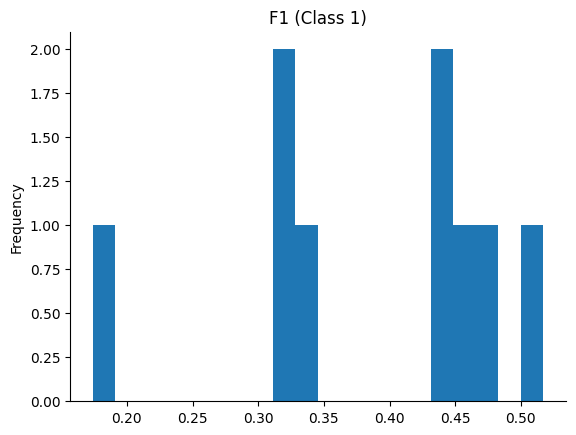

In [38]:
from matplotlib import pyplot as plt
results_df['F1 (Class 1)'].plot(kind='hist', bins=20, title='F1 (Class 1)')
plt.gca().spines[['top', 'right',]].set_visible(False)

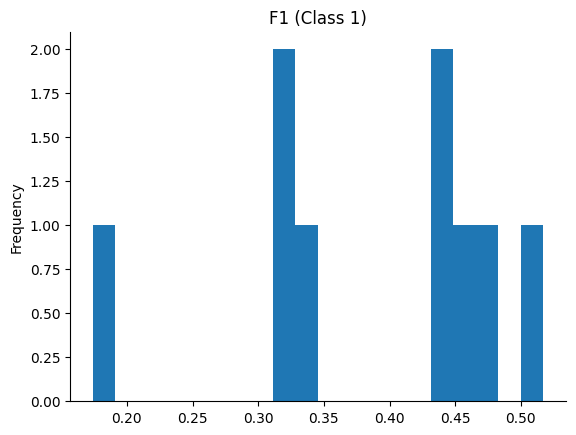

In [39]:
from matplotlib import pyplot as plt
results_df['F1 (Class 1)'].plot(kind='hist', bins=20, title='F1 (Class 1)')
plt.gca().spines[['top', 'right',]].set_visible(False)

C:\Users\owner\AppData\Local\Temp\ipykernel_28856\2107176540.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted_f1.index, y='F1 (Class 1)', data=results_df_sorted_f1, palette='viridis')


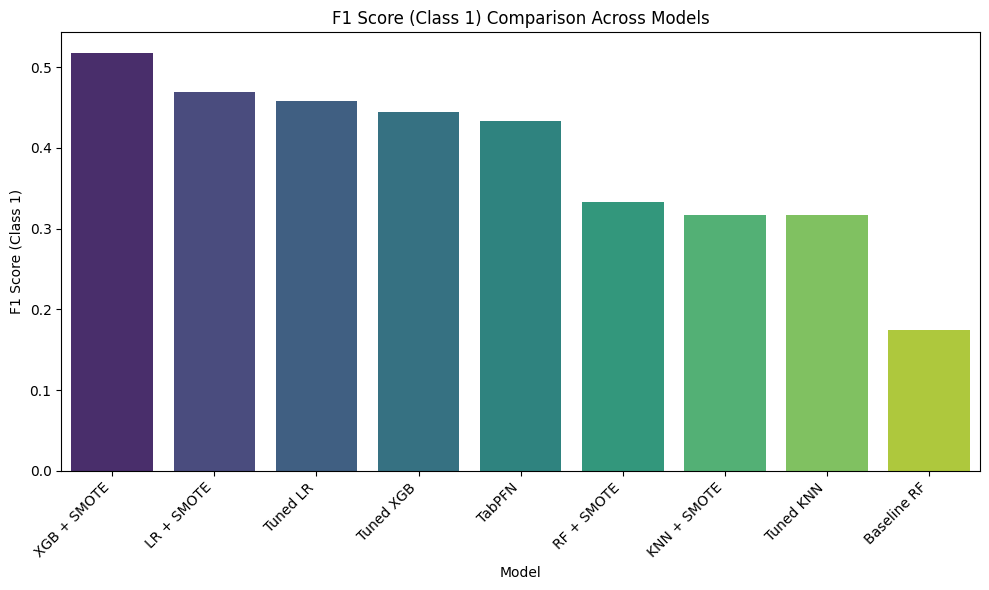

C:\Users\owner\AppData\Local\Temp\ipykernel_28856\2107176540.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted_roc.index, y='ROC-AUC', data=results_df_sorted_roc, palette='magma')


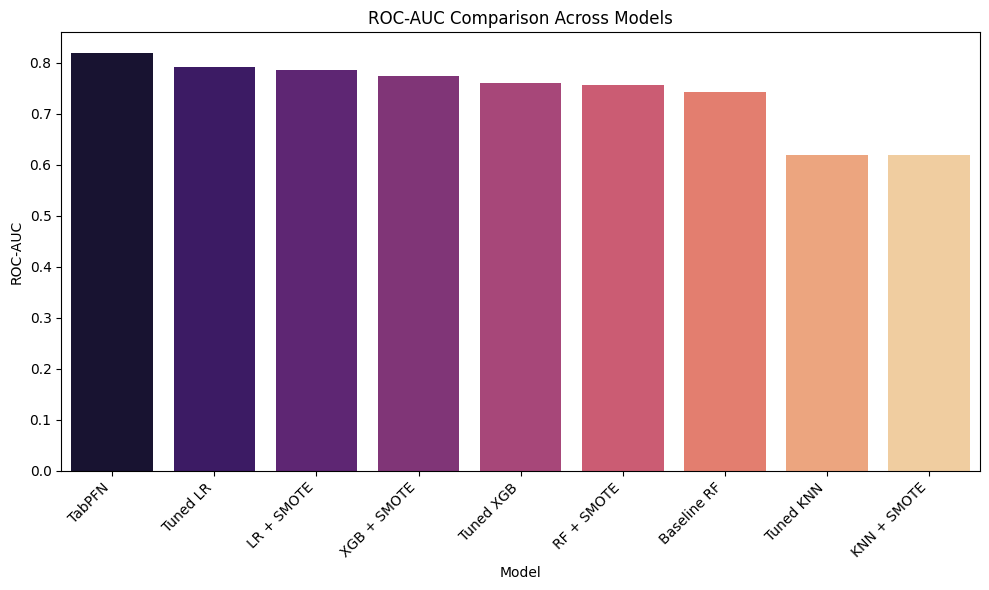

C:\Users\owner\AppData\Local\Temp\ipykernel_28856\2107176540.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_sorted_pr.index, y='PR-AUC', data=results_df_sorted_pr, palette='cividis')


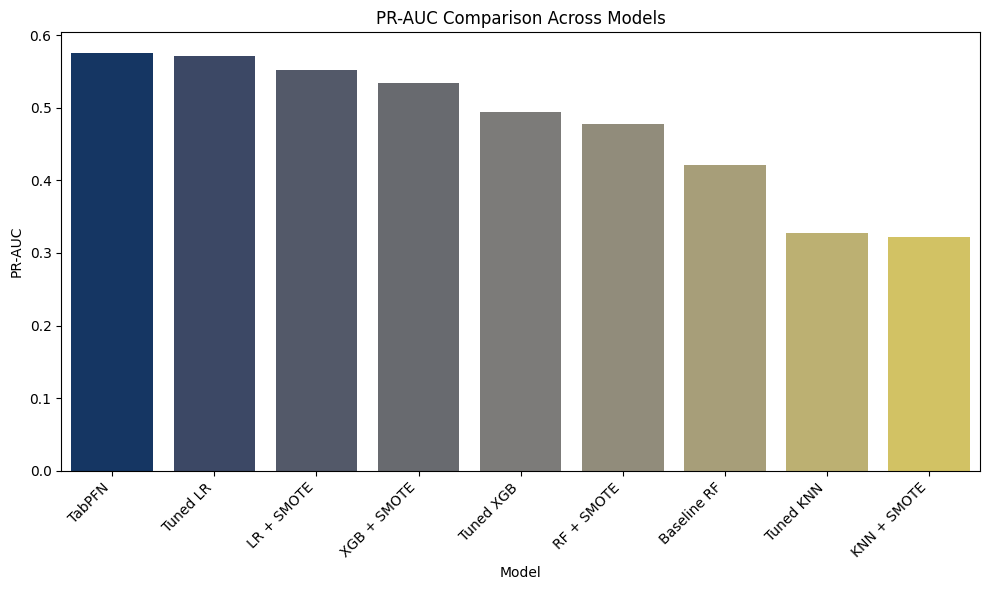

In [40]:
# Sort the DataFrame by F1 score for better visualization
results_df_sorted_f1 = results_df.sort_values('F1 (Class 1)', ascending=False)

# Plotting F1 Score
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df_sorted_f1.index, y='F1 (Class 1)', data=results_df_sorted_f1, palette='viridis')
plt.title('F1 Score (Class 1) Comparison Across Models')
plt.ylabel('F1 Score (Class 1)')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort the DataFrame by ROC-AUC for better visualization
results_df_sorted_roc = results_df.sort_values('ROC-AUC', ascending=False)

# Plotting ROC-AUC
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df_sorted_roc.index, y='ROC-AUC', data=results_df_sorted_roc, palette='magma')
plt.title('ROC-AUC Comparison Across Models')
plt.ylabel('ROC-AUC')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Sort the DataFrame by PR-AUC for better visualization
results_df_sorted_pr = results_df.sort_values('PR-AUC', ascending=False)

# Plotting PR-AUC
plt.figure(figsize=(10, 6))
sns.barplot(x=results_df_sorted_pr.index, y='PR-AUC', data=results_df_sorted_pr, palette='cividis')
plt.title('PR-AUC Comparison Across Models')
plt.ylabel('PR-AUC')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [41]:
# Refit Logistic Regression without SMOTE using corrected preprocessor
from sklearn.linear_model import LogisticRegression

pipeline_lr_nosmote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear',
        random_state=42
    ))
])

pipeline_lr_nosmote.fit(X, y)
evaluate_model(pipeline_lr_nosmote, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.9225    0.8091    0.8621       309
           1     0.3918    0.6441    0.4872        59

    accuracy                         0.7826       368
   macro avg     0.6571    0.7266    0.6746       368
weighted avg     0.8374    0.7826    0.8020       368

Confusion Matrix:
 [[250  59]
 [ 21  38]]

ROC-AUC: 0.787
PR-AUC: 0.540


In [42]:
# Threshold sweep for LR without SMOTE
y_proba_lr_ns = pipeline_lr_nosmote.predict_proba(X_test)[:, 1]
for t in np.linspace(0.1, 0.9, 9):
    y_pred_t = (y_proba_lr_ns >= t).astype(int)
    print(f"Threshold={t:.1f} | Precision={precision_score(y_test, y_pred_t):.3f} | Recall={recall_score(y_test, y_pred_t):.3f} | F1={f1_score(y_test, y_pred_t):.3f}")


Threshold=0.1 | Precision=0.209 | Recall=0.949 | F1=0.343
Threshold=0.2 | Precision=0.246 | Recall=0.847 | F1=0.382
Threshold=0.3 | Precision=0.288 | Recall=0.797 | F1=0.423
Threshold=0.4 | Precision=0.317 | Recall=0.678 | F1=0.432
Threshold=0.5 | Precision=0.392 | Recall=0.644 | F1=0.487
Threshold=0.6 | Precision=0.416 | Recall=0.542 | F1=0.471
Threshold=0.7 | Precision=0.531 | Recall=0.441 | F1=0.481
Threshold=0.8 | Precision=0.667 | Recall=0.305 | F1=0.419
Threshold=0.9 | Precision=0.846 | Recall=0.186 | F1=0.306


In [43]:
# Refit RandomForest without SMOTE
from sklearn.ensemble import RandomForestClassifier

rf_nosmote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

rf_nosmote.fit(X, y)
evaluate_model(rf_nosmote, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.8567    0.9676    0.9088       309
           1     0.4737    0.1525    0.2308        59

    accuracy                         0.8370       368
   macro avg     0.6652    0.5601    0.5698       368
weighted avg     0.7953    0.8370    0.8001       368

Confusion Matrix:
 [[299  10]
 [ 50   9]]

ROC-AUC: 0.769
PR-AUC: 0.438


In [44]:
# Threshold sweep for RF without SMOTE
y_proba_rf_ns = rf_nosmote.predict_proba(X_test)[:, 1]
for t in np.linspace(0.1, 0.9, 9):
    y_pred_t = (y_proba_rf_ns >= t).astype(int)
    print(f"Threshold={t:.1f} | Precision={precision_score(y_test, y_pred_t):.3f} | Recall={recall_score(y_test, y_pred_t):.3f} | F1={f1_score(y_test, y_pred_t):.3f}")


Threshold=0.1 | Precision=0.193 | Recall=0.881 | F1=0.316
Threshold=0.2 | Precision=0.342 | Recall=0.695 | F1=0.458
Threshold=0.3 | Precision=0.462 | Recall=0.508 | F1=0.484
Threshold=0.4 | Precision=0.528 | Recall=0.322 | F1=0.400
Threshold=0.5 | Precision=0.474 | Recall=0.153 | F1=0.231
Threshold=0.6 | Precision=0.667 | Recall=0.102 | F1=0.176
Threshold=0.7 | Precision=0.750 | Recall=0.051 | F1=0.095
Threshold=0.8 | Precision=1.000 | Recall=0.034 | F1=0.066
Threshold=0.9 | Precision=0.000 | Recall=0.000 | F1=0.000


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# Refit XGBoost without SMOTE; rely on scale_pos_weight
from xgboost import XGBClassifier

pos_weight = (len(y) - y.sum()) / y.sum()

xgb_nosmote = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        scale_pos_weight=pos_weight
    ))
])

xgb_nosmote.fit(X, y)
evaluate_model(xgb_nosmote, X_test, y_test, threshold=0.5)


Classification Report:
               precision    recall  f1-score   support

           0     0.8832    0.9547    0.9176       309
           1     0.5882    0.3390    0.4301        59

    accuracy                         0.8560       368
   macro avg     0.7357    0.6468    0.6738       368
weighted avg     0.8359    0.8560    0.8394       368

Confusion Matrix:
 [[295  14]
 [ 39  20]]

ROC-AUC: 0.767
PR-AUC: 0.494


In [46]:
# Threshold sweep for XGB without SMOTE
y_proba_xgb_ns = xgb_nosmote.predict_proba(X_test)[:, 1]
for t in np.linspace(0.1, 0.9, 9):
    y_pred_t = (y_proba_xgb_ns >= t).astype(int)
    print(f"Threshold={t:.1f} | Precision={precision_score(y_test, y_pred_t):.3f} | Recall={recall_score(y_test, y_pred_t):.3f} | F1={f1_score(y_test, y_pred_t):.3f}")


Threshold=0.1 | Precision=0.323 | Recall=0.695 | F1=0.441
Threshold=0.2 | Precision=0.414 | Recall=0.610 | F1=0.493
Threshold=0.3 | Precision=0.441 | Recall=0.508 | F1=0.472
Threshold=0.4 | Precision=0.490 | Recall=0.407 | F1=0.444
Threshold=0.5 | Precision=0.588 | Recall=0.339 | F1=0.430
Threshold=0.6 | Precision=0.652 | Recall=0.254 | F1=0.366
Threshold=0.7 | Precision=0.684 | Recall=0.220 | F1=0.333
Threshold=0.8 | Precision=0.667 | Recall=0.169 | F1=0.270
Threshold=0.9 | Precision=0.700 | Recall=0.119 | F1=0.203


In [47]:
# Collect and compare metrics for corrected pipelines
compare = {}

# Existing bests for reference (if defined earlier)
models_to_check = {
    'LR_noSMOTE': pipeline_lr_nosmote,
    'RF_noSMOTE': rf_nosmote,
    'XGB_noSMOTE': xgb_nosmote
}

for name, mdl in models_to_check.items():
    y_proba = mdl.predict_proba(X_test)[:, 1]
    precision_c, recall_c, _ = precision_recall_curve(y_test, y_proba)
    compare[name] = {
        'F1 (Class 1)': f1_score(y_test, (y_proba >= 0.5).astype(int)),
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'PR-AUC': auc(recall_c, precision_c)
    }

pd.DataFrame(compare).T.sort_values('F1 (Class 1)', ascending=False)


,F1 (Class 1),ROC-AUC,PR-AUC
LR_noSMOTE,0.487179,0.786956,0.540350
XGB_noSMOTE,0.430108,0.767155,0.494135
RF_noSMOTE,0.230769,0.769020,0.437585


In [48]:
# CV utilities: stratified splits, PR-AUC scorer, threshold search, calibration
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.calibration import CalibratedClassifierCV

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pr_auc_scorer = make_scorer(lambda y_true, y_score: auc(*precision_recall_curve(y_true, y_score)[:2]), needs_proba=True)

# Find probability threshold maximizing F1 for the positive class
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.05, 0.95, 19)
    best = (0.0, 0.0)
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best[1]:
            best = (t, f1)
    return best

# Cross-validated probability predictions for threshold tuning
def cv_probs(model):
    return cross_val_predict(model, X, y, cv=skf, method='predict_proba', n_jobs=-1)[:, 1]

# Helper to calibrate probabilities via Platt (sigmoid)
def calibrate_model(model):
    return CalibratedClassifierCV(model, method='sigmoid', cv=skf)


In [49]:
# XGBoost randomized search optimized for PR-AUC, then calibration and threshold selection
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

pos_weight = (len(y) - y.sum()) / y.sum()

xgb_base = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=400
    ))
])

param_dist = {
    'model__learning_rate': [0.02, 0.05, 0.1],
    'model__max_depth': [3, 4, 5, 6],
    'model__min_child_weight': [1, 3, 5, 7],
    'model__subsample': [0.7, 0.85, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0],
    'model__gamma': [0.0, 0.5, 1.0],
    'model__scale_pos_weight': [pos_weight]
}

xgb_search = RandomizedSearchCV(
    xgb_base,
    param_distributions=param_dist,
    n_iter=30,
    scoring=pr_auc_scorer,
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X, y)
print('Best XGB params:', xgb_search.best_params_)

xgb_best = xgb_search.best_estimator_
# Calibrate with sigmoid
xgb_cal = calibrate_model(xgb_best)
xgb_cal.fit(X, y)

# CV probs for threshold selection
xgb_cv_proba = cv_probs(xgb_cal)
xgb_best_thresh, xgb_best_f1 = find_best_threshold(y, xgb_cv_proba)
print(f'XGB CV best threshold={xgb_best_thresh:.2f}, F1={xgb_best_f1:.3f}')


Fitting 5 folds for each of 30 candidates, totalling 150 fits


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best XGB params: {'model__subsample': 0.85, 'model__scale_pos_weight': np.float64(5.191011235955056), 'model__min_child_weight': 7, 'model__max_depth': 4, 'model__learning_rate': 0.02, 'model__gamma': 0.5, 'model__colsample_bytree': 0.8}
XGB CV best threshold=0.35, F1=0.555


In [50]:
# RandomForest randomized search optimized for PR-AUC, calibration and threshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_base = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'))
])

rf_params = {
    'model__n_estimators': [200, 400, 800],
    'model__max_depth': [None, 6, 10, 16],
    'model__min_samples_split': [2, 4, 6, 10],
    'model__min_samples_leaf': [1, 2, 3, 5],
    'model__max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=rf_params,
    n_iter=25,
    scoring=pr_auc_scorer,
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_search.fit(X, y)
print('Best RF params:', rf_search.best_params_)

rf_best = rf_search.best_estimator_
rf_cal = calibrate_model(rf_best)
rf_cal.fit(X, y)

rf_cv_proba = cv_probs(rf_cal)
rf_best_thresh, rf_best_f1 = find_best_threshold(y, rf_cv_proba)
print(f'RF CV best threshold={rf_best_thresh:.2f}, F1={rf_best_f1:.3f}')


Fitting 5 folds for each of 25 candidates, totalling 125 fits


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]
  warnings.warn(


Best RF params: {'model__n_estimators': 200, 'model__min_samples_split': 6, 'model__min_samples_leaf': 5, 'model__max_features': 'log2', 'model__max_depth': 6}
RF CV best threshold=0.30, F1=0.531


In [51]:
# Logistic Regression tuning (PR-AUC), calibration, and CV threshold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr_base = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='liblinear', max_iter=1000))
])

lr_params = {
    'model__C': [0.01, 0.05, 0.1, 0.5, 1, 5],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced']
}

lr_search = GridSearchCV(
    lr_base,
    param_grid=lr_params,
    scoring=pr_auc_scorer,
    cv=skf,
    n_jobs=-1,
    verbose=1
)

lr_search.fit(X, y)
print('Best LR params:', lr_search.best_params_)

lr_best = lr_search.best_estimator_
lr_cal = calibrate_model(lr_best)
lr_cal.fit(X, y)

lr_cv_proba = cv_probs(lr_cal)
lr_best_thresh, lr_best_f1 = find_best_threshold(y, lr_cv_proba)
print(f'LR CV best threshold={lr_best_thresh:.2f}, F1={lr_best_f1:.3f}')


Fitting 5 folds for each of 24 candidates, totalling 120 fits


c:\Users\owner\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


Best LR params: {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'l1'}
LR CV best threshold=0.15, F1=0.280


In [52]:
# Soft-voting ensemble of calibrated models; weight search and threshold selection
from itertools import product

# Fit calibrated models on full train
xgb_cal.fit(X, y)
rf_cal.fit(X, y)
lr_cal.fit(X, y)

# CV probabilities for each model
proba_xgb = cv_probs(xgb_cal)
proba_rf  = cv_probs(rf_cal)
proba_lr  = cv_probs(lr_cal)

weights = [0.2, 0.3, 0.4, 0.5]

best_combo = None
best_f1 = -1
for wx, wr, wl in product(weights, weights, weights):
    if abs(wx + wr + wl - 1.0) > 1e-6:
        continue
    blended = wx*proba_xgb + wr*proba_rf + wl*proba_lr
    t, f1v = find_best_threshold(y, blended)
    if f1v > best_f1:
        best_f1 = f1v
        best_combo = (wx, wr, wl, t)

wx, wr, wl, ens_thresh = best_combo
print(f'Ensemble weights (xgb, rf, lr)=({wx:.2f}, {wr:.2f}, {wl:.2f}), best threshold={ens_thresh:.2f}, CV F1={best_f1:.3f}')


Ensemble weights (xgb, rf, lr)=(0.20, 0.30, 0.50), best threshold=0.25, CV F1=0.555


In [53]:
# Final evaluation on test set using selected thresholds
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate tuned+calibrated single models at their CV thresholds
models_eval = [
    ('XGB_cal', xgb_cal, xgb_best_thresh),
    ('RF_cal', rf_cal, rf_best_thresh),
    ('LR_cal', lr_cal, lr_best_thresh)
]

for name, mdl, th in models_eval:
    proba = mdl.predict_proba(X_test)[:, 1]
    pred = (proba >= th).astype(int)
    print(f'\n{name} @ threshold {th:.2f}')
    print(classification_report(y_test, pred, digits=4))
    print('Confusion Matrix:\n', confusion_matrix(y_test, pred))
    print(f'ROC-AUC: {roc_auc_score(y_test, proba):.3f}')
    p, r, _ = precision_recall_curve(y_test, proba)
    print(f'PR-AUC: {auc(r, p):.3f}')

# Evaluate ensemble at its CV-selected threshold
proba_xgb_test = xgb_cal.predict_proba(X_test)[:, 1]
proba_rf_test  = rf_cal.predict_proba(X_test)[:, 1]
proba_lr_test  = lr_cal.predict_proba(X_test)[:, 1]

ens_proba_test = wx*proba_xgb_test + wr*proba_rf_test + wl*proba_lr_test
ens_pred = (ens_proba_test >= ens_thresh).astype(int)

print(f"\nEnsemble @ weights=({wx:.2f},{wr:.2f},{wl:.2f}) threshold={ens_thresh:.2f}")
print(classification_report(y_test, ens_pred, digits=4))
print('Confusion Matrix:\n', confusion_matrix(y_test, ens_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, ens_proba_test):.3f}')
p, r, _ = precision_recall_curve(y_test, ens_proba_test)
print(f'PR-AUC: {auc(r, p):.3f}')



XGB_cal @ threshold 0.35
              precision    recall  f1-score   support

           0     0.8954    0.9417    0.9180       309
           1     0.5814    0.4237    0.4902        59

    accuracy                         0.8587       368
   macro avg     0.7384    0.6827    0.7041       368
weighted avg     0.8450    0.8587    0.8494       368

Confusion Matrix:
 [[291  18]
 [ 34  25]]
ROC-AUC: 0.772
PR-AUC: 0.489

RF_cal @ threshold 0.30
              precision    recall  f1-score   support

           0     0.9085    0.8997    0.9041       309
           1     0.5000    0.5254    0.5124        59

    accuracy                         0.8397       368
   macro avg     0.7042    0.7126    0.7082       368
weighted avg     0.8430    0.8397    0.8413       368

Confusion Matrix:
 [[278  31]
 [ 28  31]]
ROC-AUC: 0.774
PR-AUC: 0.432

LR_cal @ threshold 0.15
              precision    recall  f1-score   support

           0     0.9091    0.8091    0.8562       309
           1     0.

In [57]:
# Feature engineering transformer: ratios, aggregates, and flags
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        # Safe helpers
        def safe_div(a, b):
            return np.where(b==0, np.nan, a / b)
        
        # Tenure ratios
        if 'YearsAtCompany' in X_.columns:
            if 'YearsInCurrentRole' in X_.columns:
                X_['ratio_role_tenure'] = safe_div(X_['YearsInCurrentRole'], X_['YearsAtCompany'])
            if 'YearsSinceLastPromotion' in X_.columns:
                X_['ratio_since_promo'] = safe_div(X_['YearsSinceLastPromotion'], X_['YearsAtCompany'])
            if 'YearsWithCurrManager' in X_.columns:
                X_['ratio_with_manager'] = safe_div(X_['YearsWithCurrManager'], X_['YearsAtCompany'])
        
        # Income normalization
        if 'MonthlyIncome' in X_.columns and 'JobLevel' in X_.columns:
            X_['income_per_level'] = safe_div(X_['MonthlyIncome'], X_['JobLevel'])
        
        # Job hopping indicator
        if 'NumCompaniesWorked' in X_.columns and 'TotalWorkingYears' in X_.columns:
            X_['job_change_rate'] = safe_div(X_['NumCompaniesWorked'], X_['TotalWorkingYears'])
            X_['job_hopper_flag'] = (X_['job_change_rate'] > 0.35).astype(int)
        
        # Early career flag
        if 'TotalWorkingYears' in X_.columns and 'YearsAtCompany' in X_.columns:
            X_['early_career_flag'] = ((X_['TotalWorkingYears'] <= 5) & (X_['YearsAtCompany'] <= 2)).astype(int)
        
        # Aggregate satisfaction (treat ordinal integers as numeric)
        sat_cols = [c for c in ['EnvironmentSatisfaction','JobSatisfaction','RelationshipSatisfaction','WorkLifeBalance','JobInvolvement'] if c in X_.columns]
        if sat_cols:
            X_['satisfaction_sum'] = X_[sat_cols].sum(axis=1, skipna=True)
            X_['satisfaction_mean'] = X_[sat_cols].mean(axis=1, skipna=True)
        
        # OverTime flag (if categorical)
        if 'OverTime' in X_.columns:
            X_['OverTime_flag'] = (X_['OverTime'].astype(str) == 'Yes').astype(int)
        
        # Commute burden (distance normalized by salary hike as crude proxy)
        if 'DistanceFromHome' in X_.columns and 'PercentSalaryHike' in X_.columns:
            X_['commute_burden'] = safe_div(X_['DistanceFromHome'], (X_['PercentSalaryHike'] + 1))
        
        return X_


In [55]:
# Build a selector-based preprocessor that survives new engineered features
from sklearn.compose import make_column_selector

numeric_selector = make_column_selector(dtype_include=np.number)
categorical_selector = make_column_selector(dtype_exclude=np.number)

num_pipe_sel = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe_sel = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor_fe = ColumnTransformer([
    ('num', num_pipe_sel, numeric_selector),
    ('cat', cat_pipe_sel, categorical_selector)
])


In [56]:
# XGBoost with feature engineering: fit, calibrate, CV threshold, evaluate on test
from xgboost import XGBClassifier

pos_weight = (len(y) - y.sum()) / y.sum()

xgb_fe = Pipeline([
    ('feat', FeatureEngineer()),
    ('preprocessor', preprocessor_fe),
    ('model', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=42,
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=5,
        scale_pos_weight=pos_weight
    ))
])

# Calibrate
xgb_fe_cal = calibrate_model(xgb_fe)
xgb_fe_cal.fit(X, y)

# CV threshold selection
proba_cv = cv_probs(xgb_fe_cal)
best_t, best_f1 = find_best_threshold(y, proba_cv)
print(f'XGB+FE CV best threshold={best_t:.2f}, F1={best_f1:.3f}')

# Test evaluation
proba_test = xgb_fe_cal.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= best_t).astype(int)
print(classification_report(y_test, pred_test, digits=4))
print('Confusion Matrix:\n', confusion_matrix(y_test, pred_test))
print(f'ROC-AUC: {roc_auc_score(y_test, proba_test):.3f}')
p, r, _ = precision_recall_curve(y_test, proba_test)
print(f'PR-AUC: {auc(r, p):.3f}')


XGB+FE CV best threshold=0.30, F1=0.530
              precision    recall  f1-score   support

           0     0.8857    0.9029    0.8942       309
           1     0.4340    0.3898    0.4107        59

    accuracy                         0.8207       368
   macro avg     0.6598    0.6464    0.6525       368
weighted avg     0.8133    0.8207    0.8167       368

Confusion Matrix:
 [[279  30]
 [ 36  23]]
ROC-AUC: 0.756
PR-AUC: 0.472
